In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import struct
import matplotlib.ticker as ticker
import wave  

np.set_printoptions(precision=4)
pd.set_option('precision', 4)

In [2]:
class Function:
    def __init__(self, start=None, end=None, step=None):
        if start is not None and end is not None and step is not None:
            self.initializeX(start, end, step)
            self.initializeY()
    
    def initializeX(self, start, end, step):
        self.start = start
        self.end = end
        self.step = step
        self.length = int(np.ceil(np.abs(end - start) / step))
        self.X = np.arange(start, end, step)
    
    def initializeY(self):
        self.Y = np.zeros(self.length)
        
    def lin(self, a, b):
        self.Y = a * self.X + b
    
    def exp(self, a, b):
        self.Y = np.exp(-a * self.X) * b
       
    def rand(self, scale):
        self.Y = np.array([random.uniform(-scale, scale) for _ in range(0, self.length)])
        
    def my_rand(self, scale):
        a = 45;
        c = -21;
        m = 100;
        seed = 0.4546;
        l = []
        for i in range(0, self.length):
            seed = (a * seed + c) % m
            l.append(seed)
        self.Y = np.array([(((l[i] - min(l)) / (max(l) - min(l))) * 2 - 1) * scale for i in range(0, len(l))])
        
    def sin(self, A, f):
        self.Y = A * np.sin(2 * np.pi * f * self.X)
        
    def complex_sin(self, arrA, arrF):
        for i in range(0, len(A)):
            self.Y += arrA[i] * np.sin(2 * np.pi * arrF[i] * self.X)
        
    def complex_func(self, arrFunc):
        self.Y = 0
        for i in range(0, len(arrFunc)):
            self.Y += arrFunc[i].Y.copy()
            
    def multiply_func(self, arrFunc):
        self.Y = 1
        for i in range(0, len(arrFunc)):
            self.Y *= arrFunc[i].Y.copy()
        
    def trend(self, func):
        L = func.length - self.length
        for m in range(0, self.length):
            sum = 0
            for k in range(m, m + L):
                sum += func.Y[k]
            self.Y[m] = sum / L
    
    def anti_random(self, arrFuncs, scale, iterations):
        try:
            start = arrFuncs[0].start
            end = arrFuncs[0].end
            step = arrFuncs[0].step
        except:
            start = 0
            end = 1000
            step = 1
        funcRand = Function(start, end, step)
        funcComplex = Function(start, end, step)
        funcComplexArr = []
        for i in range(0, iterations):
            funcRand.rand(scale)
            funcComplex.complex_func(arrFuncs + [funcRand])
            funcComplex.Y = funcComplex.Y / iterations
            funcComplexArr.append(funcComplex.Y.copy())        
        self.Y = funcComplexArr[0]
        for i in range(1, len(funcComplexArr)):
            self.Y += funcComplexArr[i]
        
    def fourier_spectrum(self, func, window, freq=False, half=False, dt=1):
        lenZeros = int(func.length * (1 - window) / 2)
        for i in range(0, lenZeros):
            func.Y[i] = 0
            func.Y[N - i - 1] = 0
        sumRe, sumIm = 0, 0
        for k in range(0, func.length):
            sumRe += func.Y[k] * np.cos(2 * np.pi * self.X * k / func.length)
            sumIm += func.Y[k] * np.sin(2 * np.pi * self.X * k / func.length)
        Re = (1 / func.length) * sumRe
        Im = (1 / func.length) * sumIm
        self.Y = (Re ** 2 + Im ** 2) ** 0.5
        if freq:
            # переходим от параметра n к f
            df = 1 / (self.end * dt)
            self.initializeX(self.start, self.end * df, df)
        if half:
            # берём первую половину графика
            self.initializeX(self.start, int(self.end / 2), self.step)
            self.Y = np.array(list(self.Y)[:self.length])
        
    def file_func(self, path, mode, format, dt=1):
        file = open(path, mode)
        byte = file.read(4)
        data = []
        while byte:
            data.append(struct.unpack(format, byte)[0])
            byte = file.read(4)
        self.initializeX(0, len(data) * dt, dt)
        self.Y = np.array(data)
        
    def wave_func(self, file, attr):
        f = wave.open(file, attr)
        params = f.getparams()
        nchannels = params[0]
        sampwidth = params[1]
        framerate = params[2]
        nframes = params[3]

        # framerate = 22050
        # nframes = int(framerate * params.nframes / params.framerate)

        self.initializeX(0, nframes / framerate, 1 / framerate)
        str_data  = f.readframes(nframes)  
        f.close()
        self.Y = np.frombuffer(str_data, dtype = np.int16)
        self.Y.shape = -1,2
        self.Y = self.Y.T[0]
                
    def convolution_func(self, x, h):
        N = x.length
        M = h.length
        self.Y = np.zeros(N + M) # меняем количесвто значений функции
        for k in range(0, N + M):
            sum = 0
            for j in range(0, M):
                try:
                    sum += x.Y[k - j] * h.Y[j]
                except:
                    sum += 0
            self.Y[k] = sum
        self.Y = np.array(list(self.Y)[: len(self.Y) - M]) # удаляем справа M значений
        
    def normalize(self):
        maxY = self.Y.max()
        for i in range(0, self.length):
            self.Y[i] = self.Y[i] / maxY
            
    def lpf(self, fc, dt, m):
        d = [0.35577019, 0.2436983, 0.07211497, 0.00630165]
        fact = float(2 * fc)
        lpw = []
        lpw.append(fact)
        arg = fact * np.pi
        for i in range(1, m + 1):
            lpw.append(np.sin(arg * i) / (np.pi * i))
        lpw[m] /= 2
        sumg = lpw[0]
        for i in range(1, m + 1):
            sum = d[0]
            arg = np.pi * i / m
            for k in range(1, 4):
                sum += 2 * d[k] * np.cos(arg * k)
            lpw[i] *= sum
            sumg += 2 * lpw[i]
        for i in range(0, m + 1):
            lpw[i] /= sumg
        lpwRes = []
        for i in range(len(lpw) - 1, 0, -1):
            lpwRes.append(lpw[i])
        self.Y = np.array(lpwRes + lpw)
        
    def hpf(self, fc, dt, m):
        lpw = Function(0, 2 * m + 1, 1)
        lpw.lpf(fc, dt, m)
        loper = 2 * m + 1
        hpw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            if k == m:
                hpw[k] = 1 - lpw.Y[k]
            else:
                hpw[k] = -1 * lpw.Y[k]
        self.Y = np.array(hpw)
    
    def bpf(self, fc1, fc2, dt, m):
        lpw1 = Function(0, 2 * m + 1, 1)
        lpw1.lpf(fc1, dt, m)
        lpw2 = Function(0, 2 * m + 1, 1)
        lpw2.lpf(fc2, dt, m)
        loper = 2 * m + 1
        bpw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            bpw[k] = lpw2.Y[k] - lpw1.Y[k]
        self.Y = np.array(bpw)
        
    def bsf(self, fc1, fc2, dt, m):
        lpw1 = Function(0, 2 * m + 1, 1)
        lpw1.lpf(fc1, dt, m)
        lpw2 = Function(0, 2 * m + 1, 1)
        lpw2.lpf(fc2, dt, m)
        loper = 2 * m + 1
        bsw = [0 for _ in range(0, loper)]
        for k in range(0, loper):
            if k == m:
                bsw[k] = 1 + lpw1.Y[k] - lpw2.Y[k]
            else:
                bsw[k] = lpw1.Y[k] - lpw2.Y[k]
        self.Y = np.array(bsw)

    def display(self, title, xlabel='x', ylabel='y'):
        plt.plot(self.X, self.Y)
        plt.title(title)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.grid(True)

In [3]:
class Metric:
    @staticmethod
    def std_dev(func):
        return np.var(func) ** (0.5)

    @staticmethod
    def mid_sqr(func):
        sum = 0
        for val in func:
            sum += val ** 2
        return sum / len(func)

    @staticmethod
    def mid_sqr_dev(func):
        sum = 0
        for val in func:
            sum += val ** 2
        return (sum / len(func)) ** (0.5)

    @staticmethod
    def asym(func):
        sum = 0
        for val in func:
            sum += (val - np.mean(func)) ** 3
        return  sum / len(func)

    @staticmethod
    def exc(func):
        sum = 0
        for val in func:
            sum += (val - np.mean(func)) ** 4
        return sum / len(func)

    @staticmethod
    def aC(func):
        return Metric.asym(func) / (Metric.std_dev(func) ** 3)

    @staticmethod
    def eC(func):
        return (Metric.exc(func) / (Metric.std_dev(func) ** 4)) - 3

    @staticmethod
    def split_list(alist, wanted_parts=1):
        length = len(alist)
        return [ alist[i * length // wanted_parts: (i + 1) * length // wanted_parts] for i in range(wanted_parts) ]

    @staticmethod
    def split(func, M, devotion=10):
        split_func = Metric.split_list(func, wanted_parts=M)
        mean, disp = [], []
        for part in split_func:
            mean.append(np.mean(part))
            disp.append(np.var(part))
        check = True
        for i in range(0, len(mean)):
            if abs(((np.mean(func) - mean[i]) / np.mean(func)) * 100) > devotion or \
               abs(((np.var(func) - disp[i]) / np.var(func)) * 100) > devotion:
                check = False
                break
        return {'Means': mean, 'Dispersions': disp, 'Check': check}  

In [4]:
class Correlation:
    @staticmethod
    def Rxx(func):
        N = len(func)
        meanF = np.mean(func)
        corr = []
        for l in range(0, N):
            sum1 = 0
            sum2 = 0
            for k in range(0, N - l):
                sum1 += (func[k] - meanF) * (func[k + l] - meanF)
            for k in range(0, N):
                sum2 += (func[k] - meanF) * (func[k] - meanF)
            corr.append(sum1 / sum2)
        return corr

    @staticmethod
    def RxxMean(func):
        N = len(func)
        meanF = np.mean(func)
        corr = []
        for l in range(0, N):
            sum = 0
            for k in range(0, N - l):
                sum += (func[k] - meanF) * (func[k + l] - meanF)
            corr.append(sum / N)
        return corr

    @staticmethod
    def Rxy(func1, func2):
        N = len(func1)
        meanF1 = np.mean(func1)
        meanF2 = np.mean(func2)
        corr = []
        for l in range(0, N):
            sum = 0
            for k in range(0, N - l):
                sum += (func1[k] - meanF1) * (func2[k + l] - meanF2)
            corr.append(sum / N)
        return corr

In [5]:
class Damage:
    @staticmethod
    def offset(func, offset):
        return func + offset

    @staticmethod
    def emission(func):
        num_of_emissions = random.randint(1, 5)
        place_of_emissions = []
        val_of_emissions = []
        sign_of_emissions = []
        for i in range(0, num_of_emissions):
            place_of_emissions.append(random.randint(0, len(func) - 1))
            offset = random.uniform(min(func), max(func))
            offset = offset if random.randint(0, 1) else -1 * offset
            val_of_emissions.append(max(func) * 10 * random.uniform(1, 3) + offset)
            sign_of_emissions.append(1 if random.randint(0, 1) else -1)
            func[place_of_emissions[i]] = val_of_emissions[i] * sign_of_emissions[i]   
        return func
    
    @staticmethod
    def anti_offset(func):
        return Damage.offset(func, -np.mean(func))
    
    @staticmethod
    def get_indexes(func, index, scale):
        res_index_further =  None
        res_index_backward =  None
        if index != len(func) - 1:
            for i in range(index + 1, len(func)):
                if func[i] < scale and func[i] > -scale:
                    res_index_further = i
                    break
        if index != 0:
            for i in range(index - 1, -1, -1):
                if func[i] < scale and func[i] > -scale:
                    res_index_backward = i
                    break
        return [res_index_backward, res_index_further]
            
    @staticmethod
    def anti_emission(func, scale):
        for i in range(1, len(func) - 1):
            if func[i] > scale or func[i] < -scale:
                func[i] = (func[Damage.get_indexes(func, i, scale)[0]] + func[Damage.get_indexes(func, i, scale)[1]]) / 2
        if func[0] > scale or func[0] < -scale:
            func[0] = func[Damage.get_indexes(func, 0, scale)[1]]
        if func[len(func) - 1] > scale or func[len(func) - 1] < -scale:
            func[len(func) - 1] = func[Damage.get_indexes(func, len(func) - 1, scale)[0]]
        return func

<h4><b>Задание 1:</b></h4>

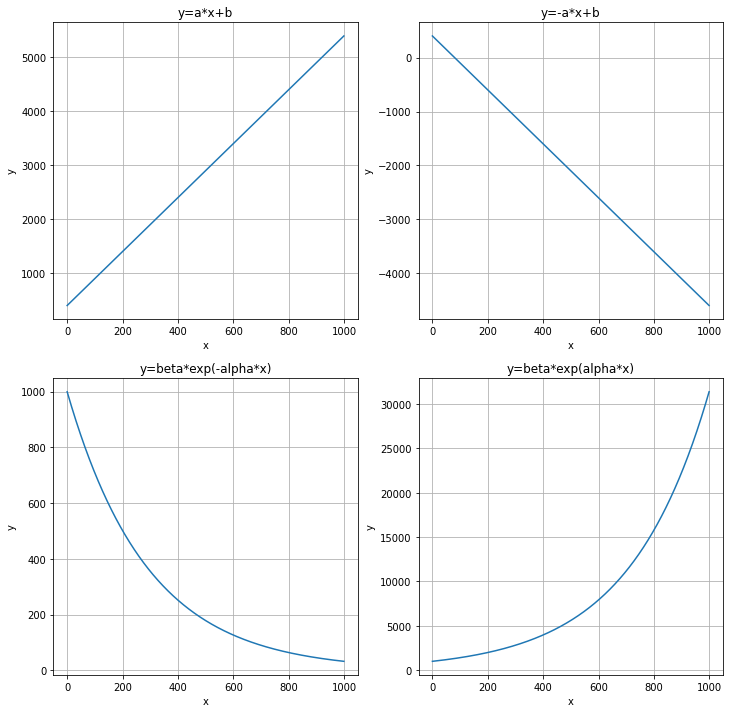

In [6]:
func = Function(0, 1000, 1)

plt.figure(figsize=(12, 12))
plt.subplot(2, 2, 1)
func.lin(5, 400)
func.display('y=a*x+b')

plt.subplot(2, 2, 2)
func.lin(-5, 400)
func.display('y=-a*x+b')

plt.subplot(2, 2, 3)
func.exp(0.00345, 1000)
func.display('y=beta*exp(-alpha*x)')

plt.subplot(2, 2, 4)
func.exp(-0.00345, 1000)
func.display('y=beta*exp(alpha*x)')

<h4><b>Задание 2:</b></h4>

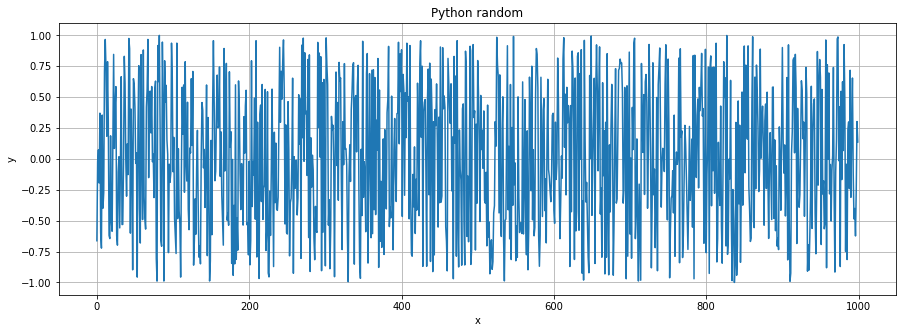

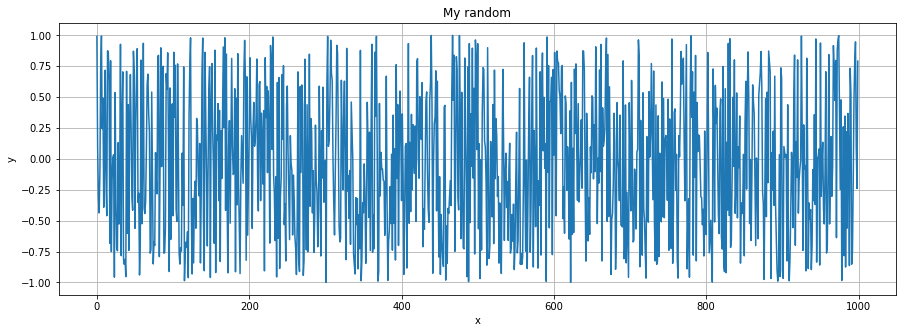

In [7]:
func = Function(0, 1000, 1)

plt.figure(figsize=(15, 5))
func.rand(1)
func.display('Python random')

plt.figure(figsize=(15, 5))
func.my_rand(1)
func.display('My random')

<h4><b>Задание 3:</b></h4>

In [8]:
func = Function(0, 1000, 1)
func.rand(1)

keys = ['Min:', 'Max:', 'Mean:', 'Dispersion:', 'Standart deviation:', 'Middle square:', 'Middle square deviation:',
        'Asymmetry:', 'Excess:', 'aC:', 'eC:']
values = [min(func.Y), max(func.Y), np.mean(func.Y), np.var(func.Y), Metric.std_dev(func.Y), Metric.mid_sqr(func.Y), Metric.mid_sqr_dev(func.Y),
          Metric.asym(func.Y), Metric.exc(func.Y), Metric.aC(func.Y), Metric.eC(func.Y)]
  
output = pd.Series(values, index=keys)
print(output)

Min:                       -0.9971
Max:                        0.9995
Mean:                       0.0011
Dispersion:                 0.3345
Standart deviation:         0.5784
Middle square:              0.3345
Middle square deviation:    0.5784
Asymmetry:                  0.0013
Excess:                     0.2009
aC:                         0.0069
eC:                        -1.2049
dtype: float64


Random function:
    Means  Dispersions
0 -0.0115       0.3470
1  0.0122       0.3746
2 -0.0419       0.3242
3  0.0271       0.3194
4 -0.0772       0.3152
5  0.0328       0.3369
6  0.0573       0.3176
7  0.0046       0.3127
8  0.0201       0.3454
9 -0.0123       0.3386
Stationarity:  False 

Trend function:
      Means  Dispersions
0  847.1978    7104.3235
1  600.0028    3563.3587
2  424.9342    1787.2954
3  300.9470     896.4646
4  213.1368     449.6452
5  150.9478     225.5313
6  106.9043     113.1211
7   75.7118      56.7388
8   53.6206      28.4588
9   37.9752      14.2743
Stationarity:  False


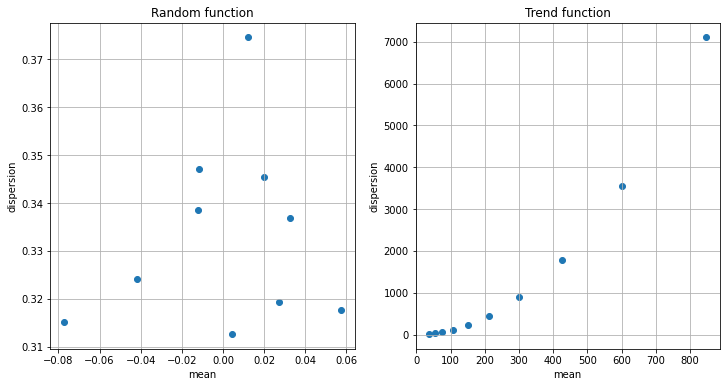

In [9]:
plt.figure(figsize=(12, 6))

split_metrics = Metric.split(func.Y, 10, 10)
df = pd.DataFrame({
    'Means': split_metrics['Means'], 
    'Dispersions': split_metrics['Dispersions']
}, index=None)
print('Random function:')
print(df)
print('Stationarity: ', split_metrics['Check'], '\n')

plt.subplot(1, 2, 1)
plt.scatter(split_metrics['Means'], split_metrics['Dispersions'], lw=1)
plt.xlabel('mean')
plt.ylabel('dispersion')
plt.title('Random function')
plt.grid(True)

func.exp(0.00345, 1000)
split_metrics = Metric.split(func.Y, 10, 10)
df = pd.DataFrame({
    'Means': split_metrics['Means'], 
    'Dispersions': split_metrics['Dispersions']
}, index=None)
print('Trend function:')
print(df)
print('Stationarity: ', split_metrics['Check'])

plt.subplot(1, 2, 2)
plt.scatter(split_metrics['Means'], split_metrics['Dispersions'], lw=1)
plt.xlabel('mean')
plt.ylabel('dispersion')
plt.title('Trend function')
plt.grid(True)

<h4><b>Задание 4:</b></h4>

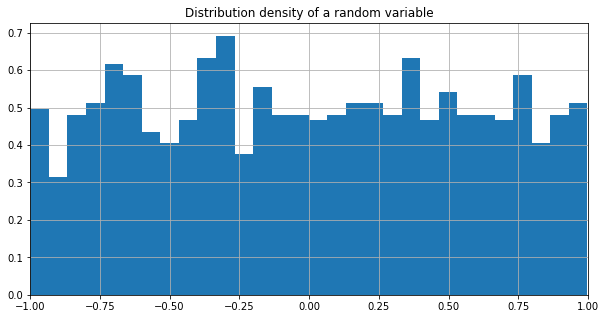

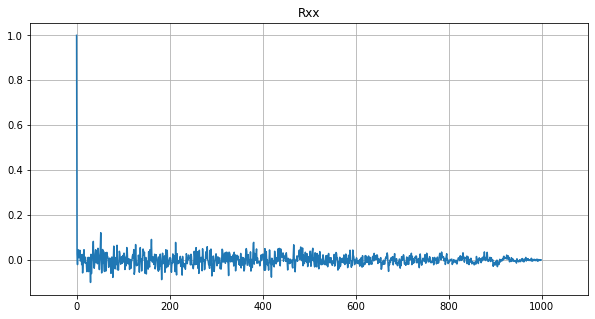

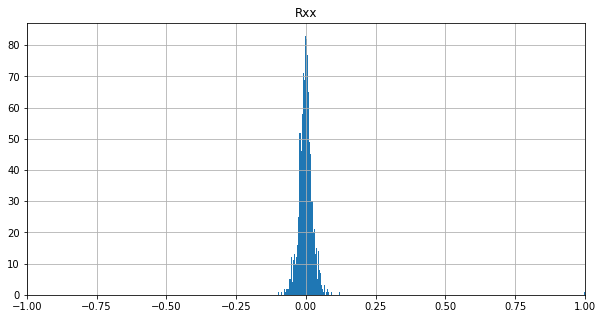

In [10]:
N = 1000
scale = 1

func1 = Function(0, N, 1)
func1.rand(scale)

func2 = Function(0, N, 1)
func2.rand(scale)

Rxx = Correlation.Rxx(func1.Y)

plt.figure(figsize=(10, 5))
plt.hist(func1.Y, 30, density=True)
plt.xlim(-scale, scale)
plt.title('Distribution density of a random variable')
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.plot(func1.X, Rxx)
plt.xlim(-0.1 * N, N + 0.1 * N)
plt.title('Rxx')
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.hist(Rxx, 300)
plt.xlim(-scale, scale)
plt.title('Rxx')
plt.grid(True)

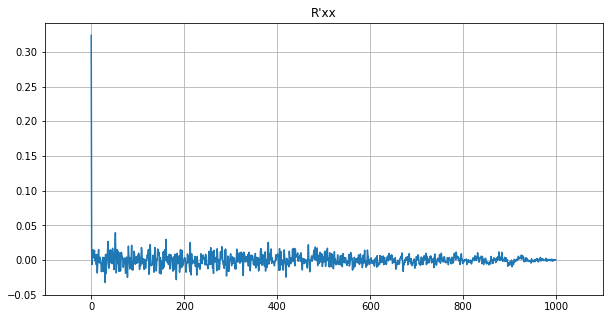

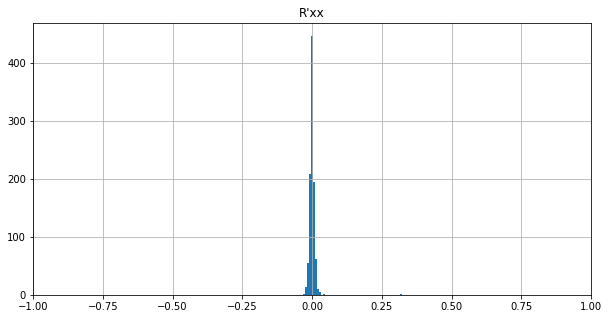

In [11]:
RxxMean = Correlation.RxxMean(func1.Y)

plt.figure(figsize=(10, 5))
plt.plot(func1.X, RxxMean)
plt.xlim(-0.1 * N, N + 0.1 * N)
plt.title('R\'xx')
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.hist(RxxMean, 50)
plt.xlim(-scale, scale)
plt.title('R\'xx')
plt.grid(True)

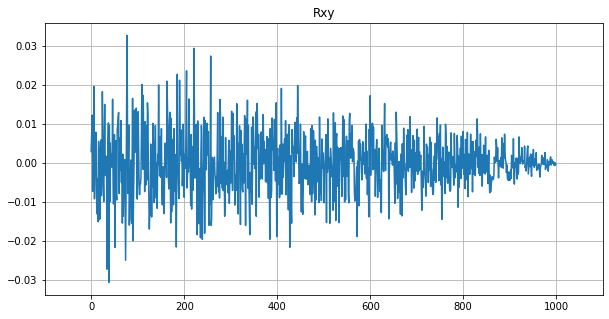

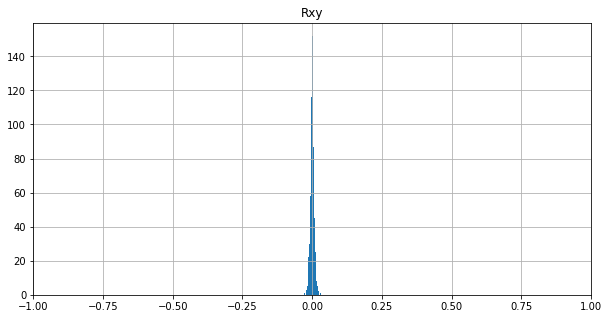

In [12]:
Rxy = Correlation.Rxy(func1.Y, func2.Y)

plt.figure(figsize=(10, 5))
plt.plot(func1.X, Rxy)
plt.xlim(-0.1 * N, N + 0.1 * N)
plt.title('Rxy')
plt.grid(True)

plt.figure(figsize=(10, 5))
plt.hist(Rxy, 30)
plt.xlim(-scale, scale)
plt.title('Rxy')
plt.grid(True)

<h4><b>Задание 5:</b></h4>

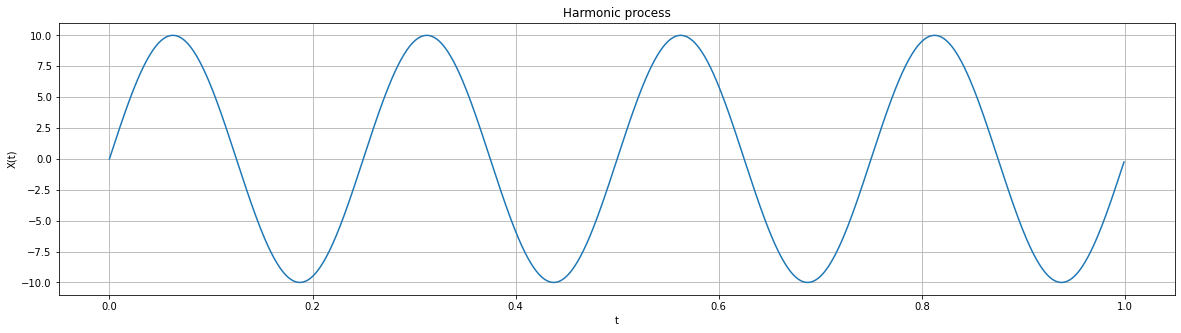

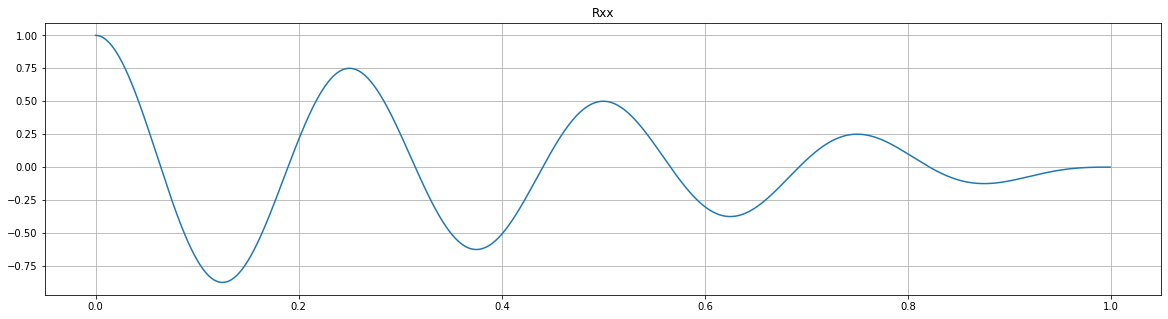

In [13]:
N = 1000
A = 10
f = 4
dt = 0.001

func1 = Function(0, N * dt, dt)
func1.sin(A, f)

plt.figure(figsize=(20, 5))
func1.display('Harmonic process', 't', 'X(t)')

Rxx = Correlation.Rxx(func1.Y)

plt.figure(figsize=(20, 5))
plt.plot(func1.X, Rxx)
plt.title('Rxx')
plt.grid(True)

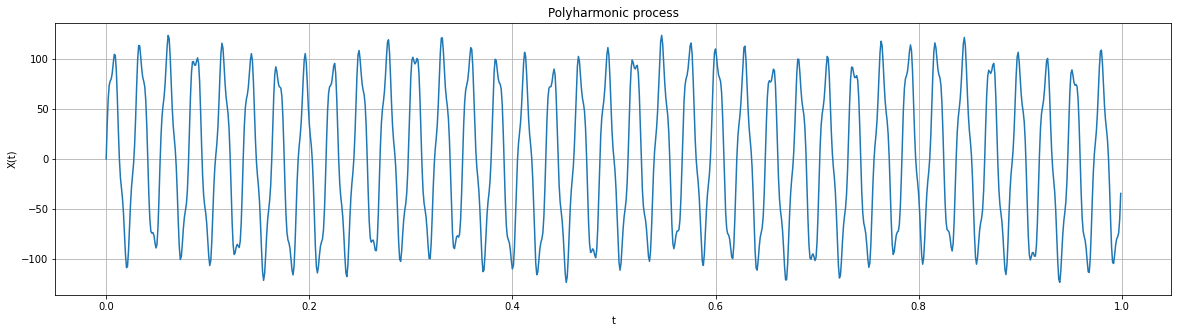

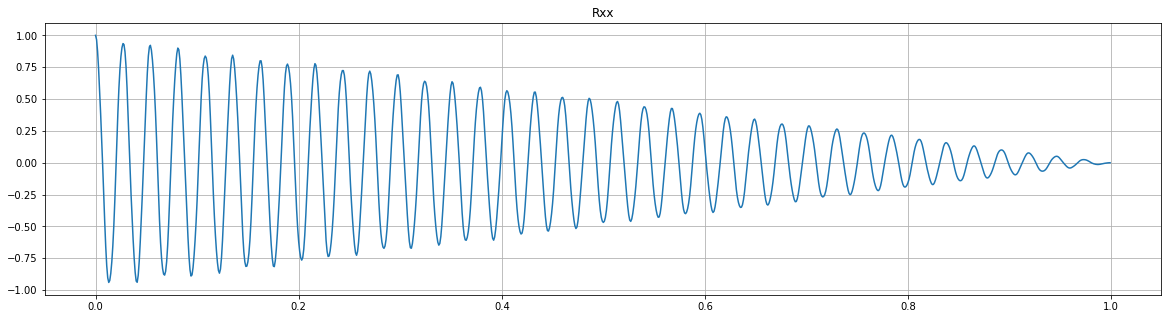

In [14]:
N = 1000
A = [10, 100, 15]
f = [4, 37, 134]
dt = 0.001

func2 = Function(0, N * dt, dt)
func2.complex_sin(A, f)
    
plt.figure(figsize=(20, 5))
func2.display('Polyharmonic process', 't', 'X(t)')

Rxx = Correlation.Rxx(func2.Y)

plt.figure(figsize=(20, 5))
plt.plot(func2.X, Rxx)
plt.title('Rxx')
plt.grid(True)

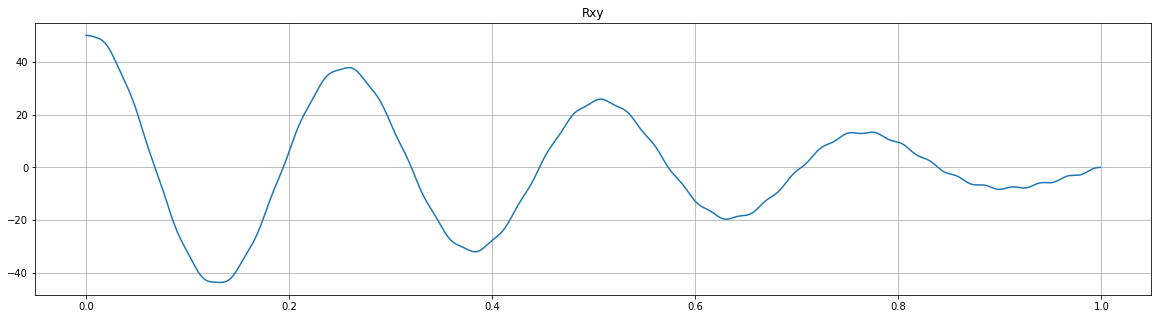

In [15]:
Rxy = Correlation.Rxy(func1.Y, func2.Y)

plt.figure(figsize=(20, 5))
plt.plot(func1.X, Rxy)
plt.title('Rxy')
plt.grid(True)

<h4><b>Задание 6:</b></h4>

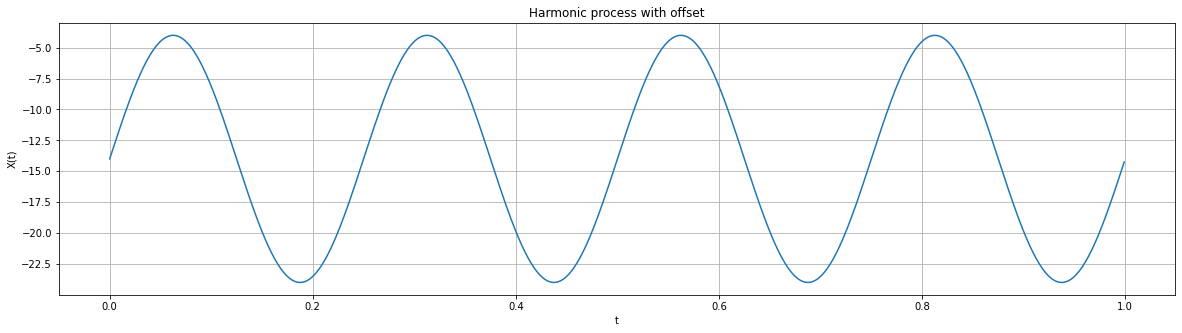

In [16]:
N = 1000
A = 10
f = 4
dt = 0.001

func1 = Function(0, N * dt, dt)
func1.sin(A, f)
func1.Y = Damage.offset(func1.Y, -14)
plt.figure(figsize=(20, 5))
func1.display('Harmonic process with offset', 't', 'X(t)')

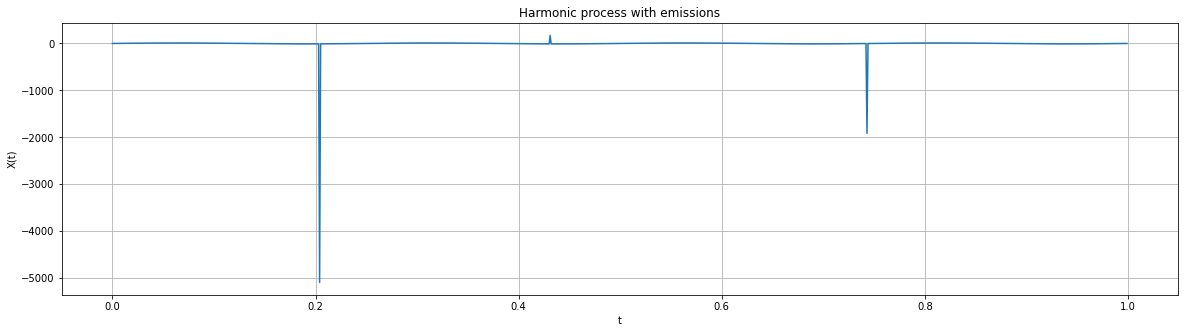

In [17]:
func2 = Function(0, N * dt, dt)
func2.sin(A, f)
func2.Y = Damage.emission(func2.Y)
plt.figure(figsize=(20, 5))
func2.display('Harmonic process with emissions', 't', 'X(t)')

<h4><b>Задание 7:</b></h4>

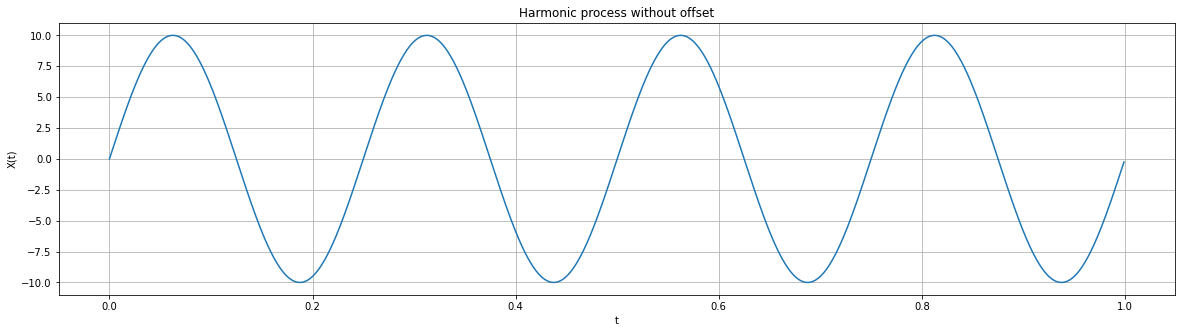

In [18]:
func1.Y = Damage.anti_offset(func1.Y)
plt.figure(figsize=(20, 5))
func1.display('Harmonic process without offset', 't', 'X(t)')

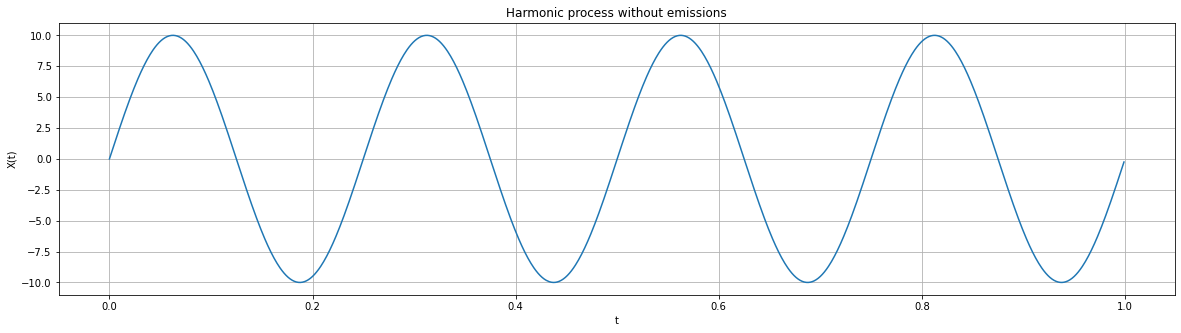

In [19]:
func2.Y = Damage.anti_emission(func2.Y, A)
plt.figure(figsize=(20, 5))
func2.display('Harmonic process without emissions', 't', 'X(t)')

<h4><b>Задание 8:</b></h4>

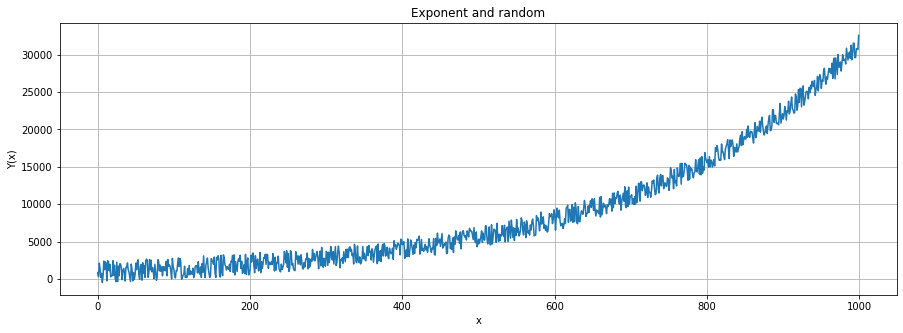

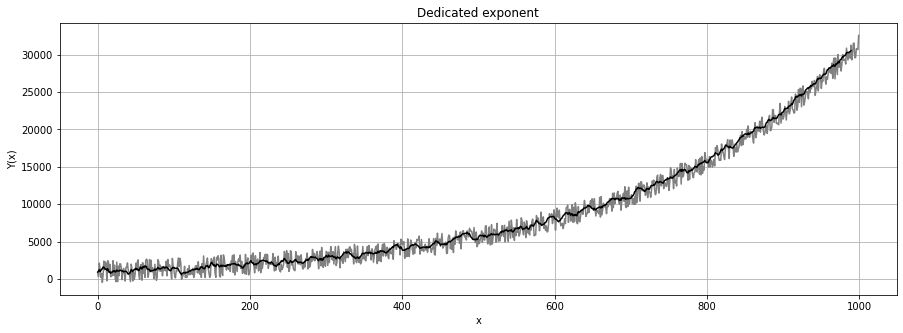

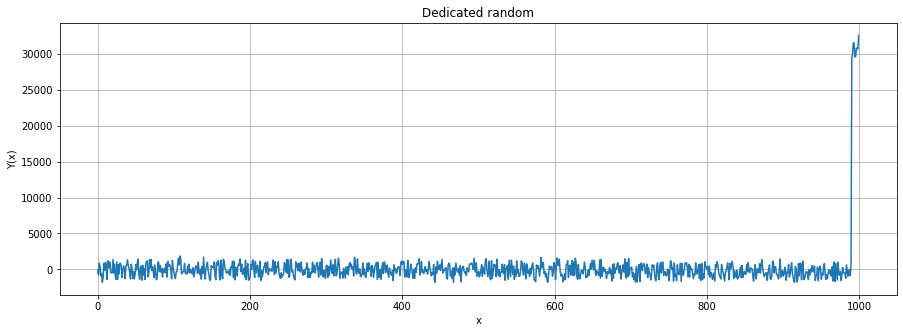

In [20]:
start = 0 # начальное значение
N = 1000 # количество значений
step = 1 # шаг по умолчанию
L = 10 # осредняющее окно

# Аддитивная модель тренда и случайного шума
funcExp = Function(start, N, step)
funcExp.exp(-0.00345, 1000)

funcRand = Function(start, N, step)
funcRand.rand(1500)

funcComplex = Function(start, N, step)
funcComplex.complex_func([funcExp, funcRand])

plt.figure(figsize=(15, 5))
funcComplex.display('Exponent and random', 'x', 'Y(x)')

# Выделен тренд методом скользящего среднего (осредняющего окна L).
funcApp = Function(start, N - L, step)
funcApp.trend(funcComplex)

plt.figure(figsize=(15, 5))
plt.title('Dedicated exponent')
plt.xlabel('x')
plt.ylabel('Y(x)')
plt.plot(funcComplex.X, funcComplex.Y, color='gray') 
plt.plot(funcApp.X, funcApp.Y, color='black')  
plt.grid(True)

funcApp.X = np.arange(0, 1000, 1)
funcApp.Y = np.array(list(-1 * funcApp.Y) + [0] * (L))
funcComplex.Y = funcApp.Y + funcComplex.Y
plt.figure(figsize=(15, 5))
funcComplex.display('Dedicated random', 'x', 'Y(x)')

Std(1): 891.6097212406363
Std(10): 306.03645790185624
Std(100): 135.50320832821157
Std(1000): 110.10190825497665


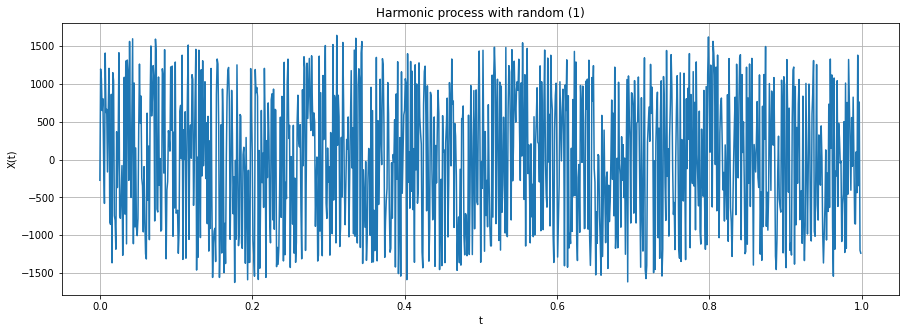

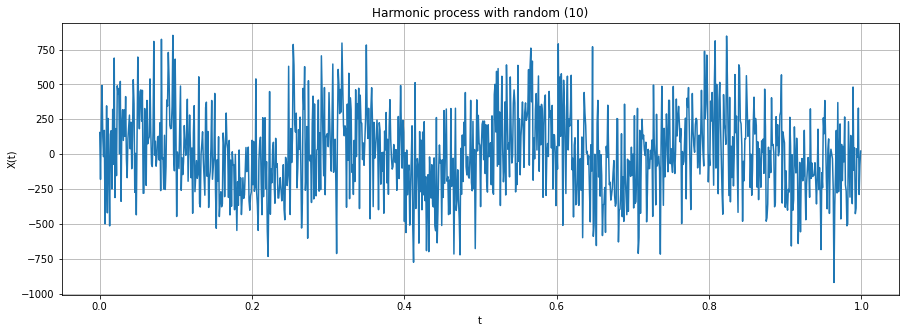

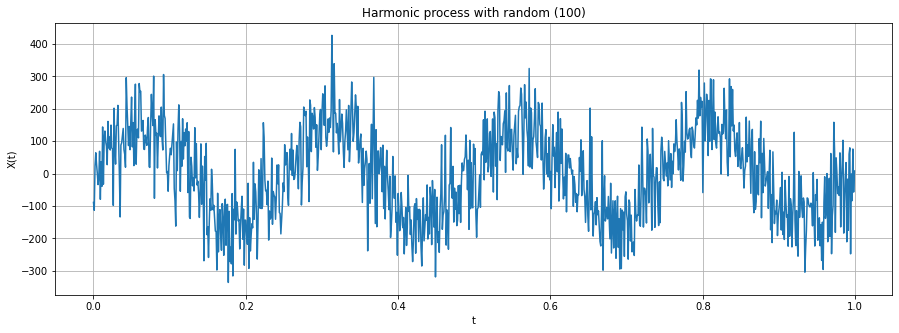

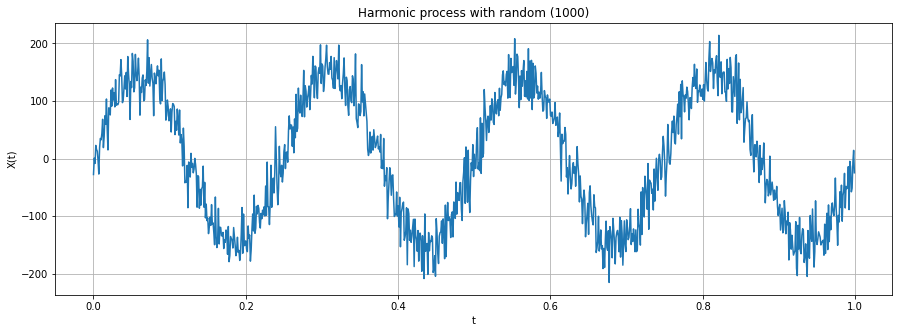

In [21]:
start = 0 # начальное значение
N = 1000 # количество значений
step = 1 # шаг по умолчанию
dt = 0.001 # шаг дискретизации
A = 150 # амплитуда гармонического процесса
f = 4 # частота
scale = 1500 # разброс случайной величины

# Гармонический процесс
funcSin = Function(start, N * dt, dt)
funcSin.sin(A, f)

# Функции синхронного накопления с усреднением для случаев 1, 10, 100 и 1000 накоплений (подавление шума в гармоническом процессе)
funcAntiRand = Function(start, N * dt, dt)

funcAntiRand.anti_random([funcSin], scale, 1)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (1)', 't', 'X(t)')
print('Std(1):', Metric.std_dev(funcAntiRand.Y))

funcAntiRand.anti_random([funcSin], scale, 10)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (10)', 't', 'X(t)')
print('Std(10):', Metric.std_dev(funcAntiRand.Y))

funcAntiRand.anti_random([funcSin], scale, 100)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (100)', 't', 'X(t)')
print('Std(100):', Metric.std_dev(funcAntiRand.Y))

funcAntiRand.anti_random([funcSin], scale, 1000)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (1000)', 't', 'X(t)')
print('Std(1000):', Metric.std_dev(funcAntiRand.Y))

Std(1): 849.0673908297032
Std(10): 261.7439411859426
Std(100): 87.49138373837472
Std(1000): 27.725475823828724


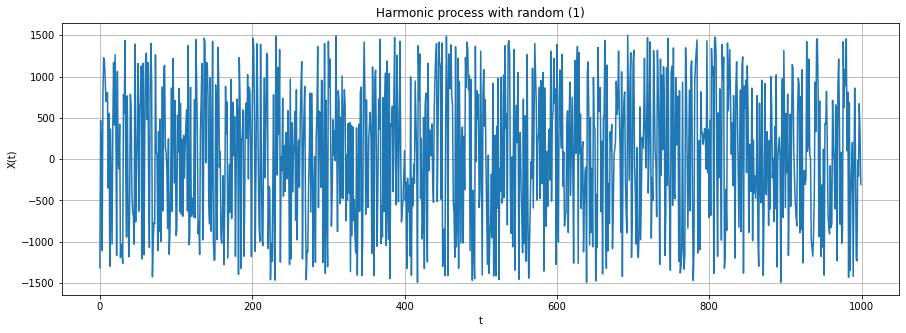

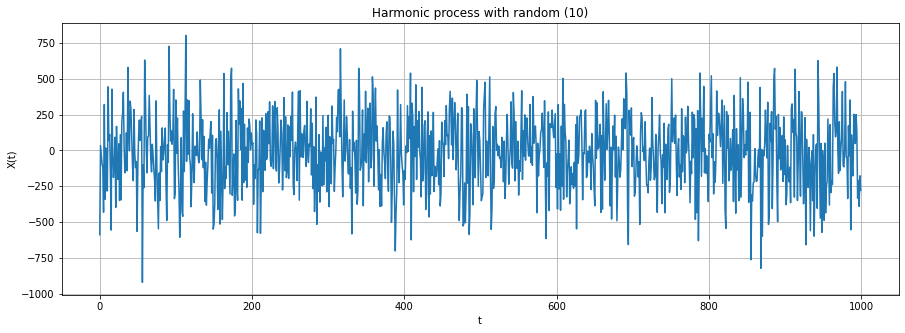

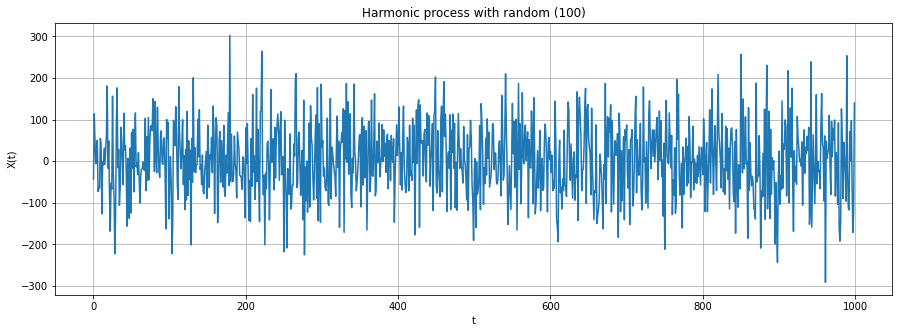

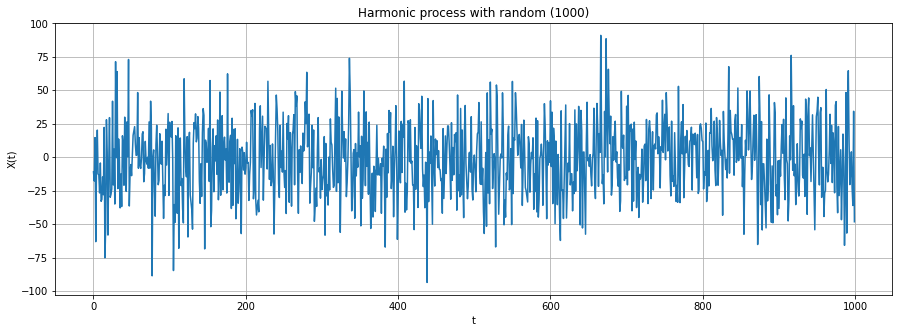

In [22]:
N = 1000 # количество значений
start = 0 # начальное значение
step = 1 # шаг по умолчанию
scale = 1500 # разброс случайной величины

# Функции синхронного накопления с усреднением для случаев 1, 10, 100 и 1000 накоплений (подавление шума в случайном процессе)
funcAntiRand = Function(start, N, step)

funcAntiRand.anti_random([], scale, 1)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (1)', 't', 'X(t)')
print('Std(1):', Metric.std_dev(funcAntiRand.Y))

funcAntiRand.anti_random([], scale, 10)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (10)', 't', 'X(t)')
print('Std(10):', Metric.std_dev(funcAntiRand.Y))

funcAntiRand.anti_random([], scale, 100)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (100)', 't', 'X(t)')
print('Std(100):', Metric.std_dev(funcAntiRand.Y))

funcAntiRand.anti_random([], scale, 1000)
plt.figure(figsize=(15, 5))
funcAntiRand.display('Harmonic process with random (1000)', 't', 'X(t)')
print('Std(1000):', Metric.std_dev(funcAntiRand.Y))

In [23]:
# funcAntiRand = Function(start, N * dt, dt)
# funcAntiRand.anti_random(start, N, step, dt, A, f, scale, 1)
# std1 = Metric.std_dev(funcAntiRand.Y)

# X = np.arange(1, 1001)
# Y = []

# for i in range(1, 1001):
#     funcAntiRand.anti_random(start, N, step, dt, A, f, scale, i)
#     Y.append(std1 / Metric.std_dev(funcAntiRand.Y))

# plt.figure(figsize=(15, 5))
# plt.title('STD1/STDi')
# plt.xlabel('x')
# plt.ylabel('Y(x)')
# plt.plot(X, Y) 
# plt.grid(True)

In [24]:
# funcAntiRand = Function(start, N * dt, dt)
# funcAntiRand.anti_random(start, N, step, dt, A, f, scale, 1)
# std1 = Metric.std_dev(funcAntiRand.Y)

# X = np.arange(1, 1001)
# Y = []

# for i in range(1, 1001):
#     funcAntiRand.anti_random(start, N, step, dt, A, f, scale, i)
#     Y.append(std1 / Metric.std_dev(funcAntiRand.Y))

# plt.figure(figsize=(15, 5))
# plt.title('STD1/STDi')
# plt.xlabel('x')
# plt.ylabel('Y(x)')
# plt.plot(X, Y) 
# plt.grid(True)

<h4><b>Задание 9:</b></h4>

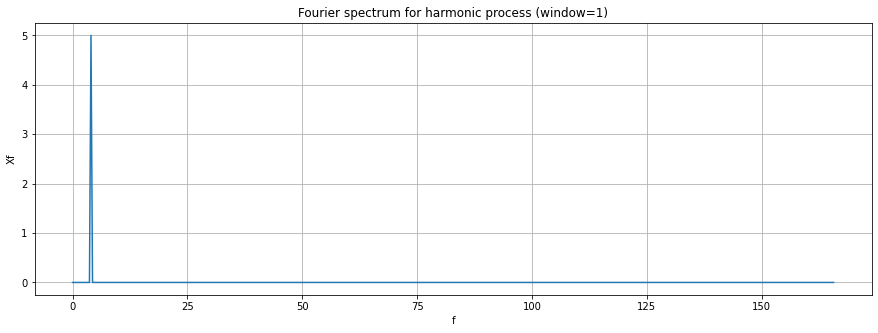

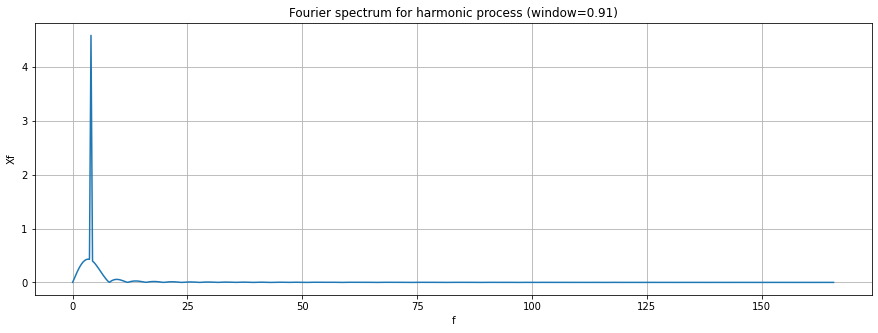

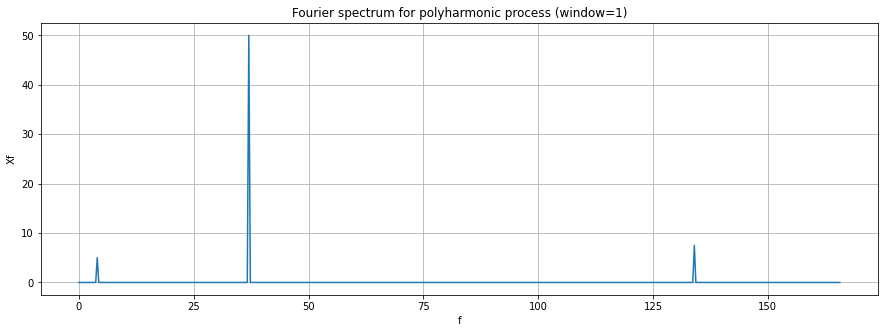

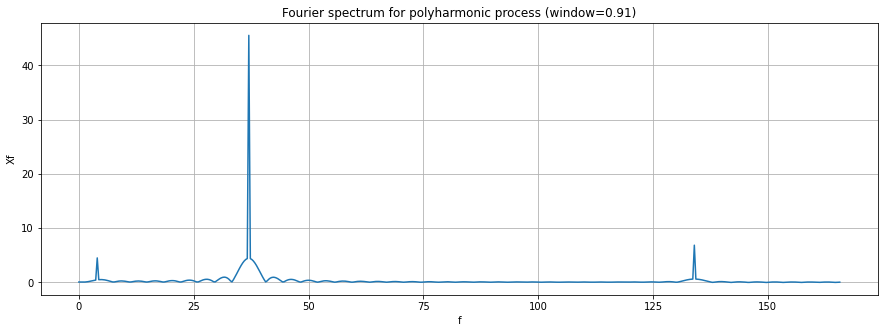

In [25]:
start = 0 # начальное значение
N = 1000 # количество значений
step = 1 # шаг по умолчанию
dt = 0.003 # приращение по времени (шаг дискретизации)

A = 10 # амплитуда синусоиды
f = 4 # частота
# Синусоида (гармонический процесс)
funcSin = Function(start, N * dt, dt)
funcSin.sin(A, f)

# Спектры Фурье для гармонического процесса
funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcSin, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Fourier spectrum for harmonic process (window=1)', 'f', 'Xf')

funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcSin, 0.91, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Fourier spectrum for harmonic process (window=0.91)', 'f', 'Xf')

A = [10, 100, 15] # амплитуды синусоиды
f = [4, 37, 134] # частоты синусоиды
# Сложная синусоида (полигармонический процесс)
funcSinComp = Function(0, N * dt, dt)
funcSinComp.complex_sin(A, f)

# Спектры Фурье для полигармонического процесса
funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcSinComp, 1, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Fourier spectrum for polyharmonic process (window=1)', 'f', 'Xf')

funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcSinComp, 0.91, True, True, dt)
plt.figure(figsize=(15, 5))
funcFourier.display('Fourier spectrum for polyharmonic process (window=0.91)', 'f', 'Xf')

<h4><b>Задание 10:</b></h4>

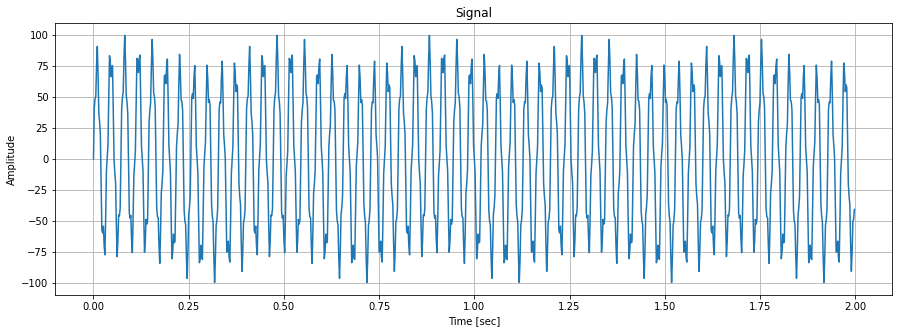

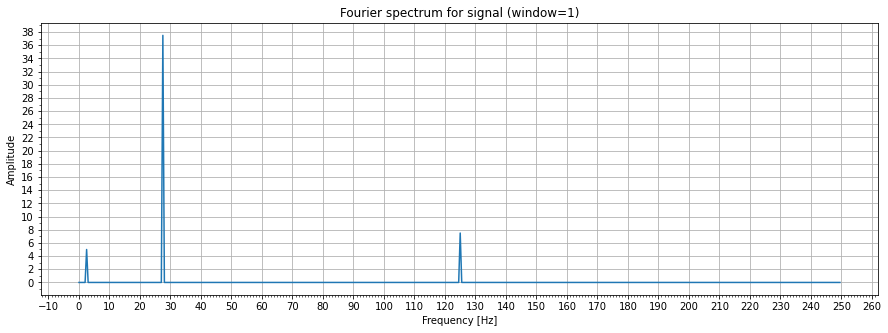

In [26]:
dt = 0.002 # приращение по времени (шаг дискретизации)

# Читаем файл, строим график данных
funcFile = Function()
funcFile.file_func('pgp_float4_1000_2ms.dat', 'rb', '<f', dt)
plt.figure(figsize=(15, 5))
funcFile.display('Signal', 'Time [sec]', 'Amplitude')

# Спектры Фурье для функции из файла
funcFourier = Function(funcFile.start, funcFile.end / dt, funcFile.step / dt)
funcFourier.fourier_spectrum(funcFile, 1, True, True, dt)
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(2))
ax.yaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Fourier spectrum for signal (window=1)', 'Frequency [Hz]', 'Amplitude')

In [27]:
print('Амплитуды: ' + str(np.round(funcFourier.Y[5] * 2, 0)) + '; ' + str(np.round(funcFourier.Y[55] * 2, 0)) + '; ' + str(np.round(funcFourier.Y[250] * 2, 0)))
print('Частоты: ' + str(funcFourier.X[5]) + '; ' + str(funcFourier.X[55]) + '; ' + str(funcFourier.X[250]))

Амплитуды: 10.0; 75.0; 15.0
Частоты: 2.5; 27.5; 125.0


<h4><b>Задание 11:</b></h4>

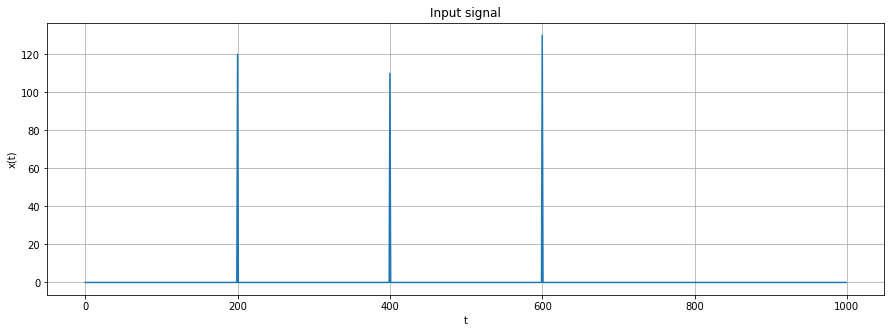

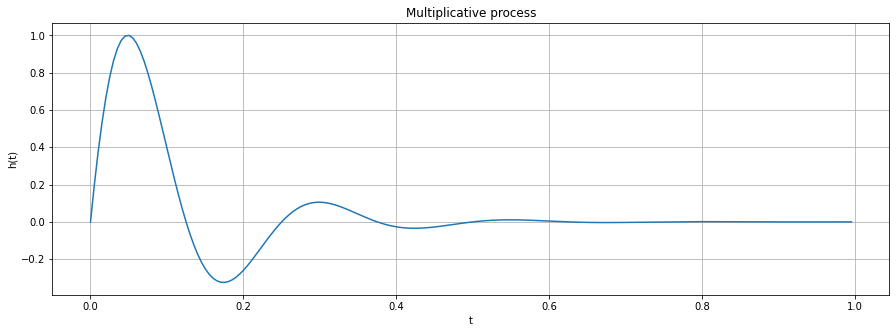

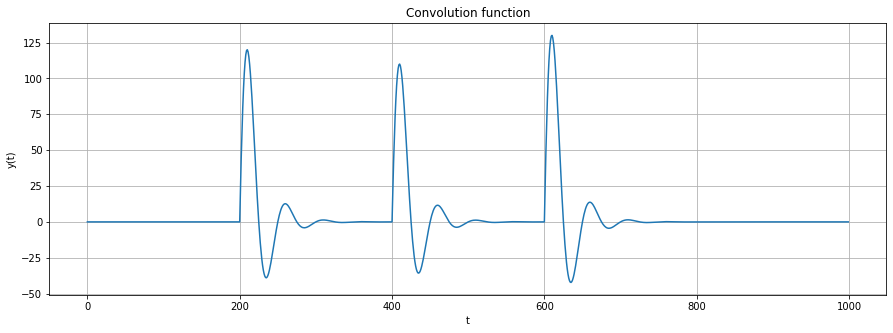

In [28]:
N = 1000 # количество значений в входном сигнале
M = 200 # количество значений в функции h
start = 0 # начальное значение
step = 1 # шаг по умолчанию
dt = 0.005 # шаг дискретизации

A = 10 # амплитуда гармонического процесса
f = 4 # частота
# параметры экспоненты
a = 9
b = 1

# Входной сигнал
x = Function(start, N, step)
x.Y[200] = 120
x.Y[400] = 110
x.Y[600] = 130
plt.figure(figsize=(15, 5))
x.display('Input signal', 't', 'x(t)')

# Мультипликативная функция h
funcExp = Function(start, M * dt, dt)
funcExp.exp(a, b)
funcSin = Function(start, M * dt, dt)
funcSin.sin(A, f)
h = Function(start, M * dt, dt)
h.multiply_func([funcExp, funcSin])
h.normalize()
plt.figure(figsize=(15, 5))
h.display('Multiplicative process', 't', 'h(t)')

# Функция свёртки
funcConv = Function(start, N, step)
funcConv.convolution_func(x, h)
plt.figure(figsize=(15, 5))
funcConv.display('Convolution function', 't', 'y(t)')

<h4><b>Задание 12:</b></h4>

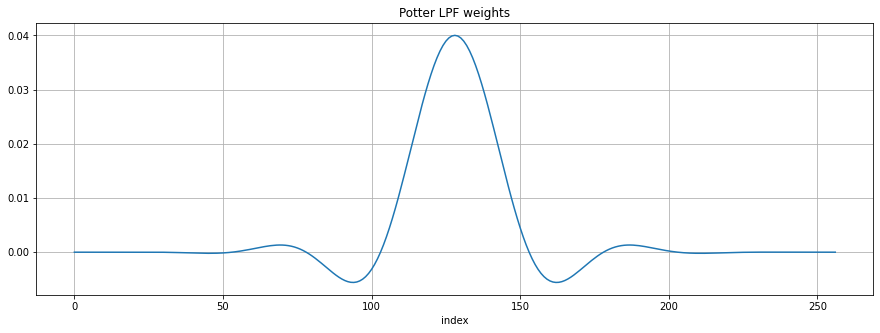

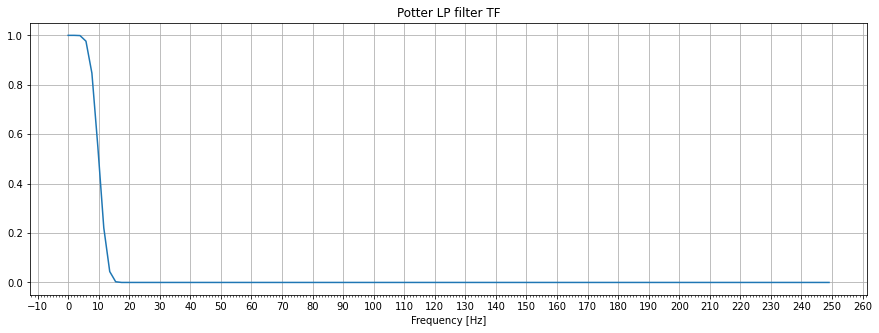

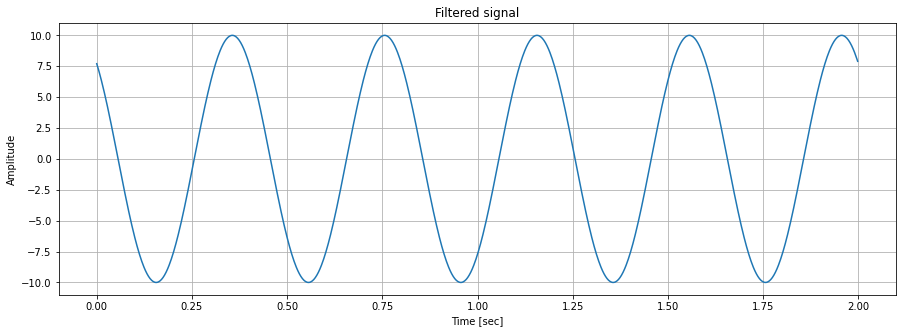

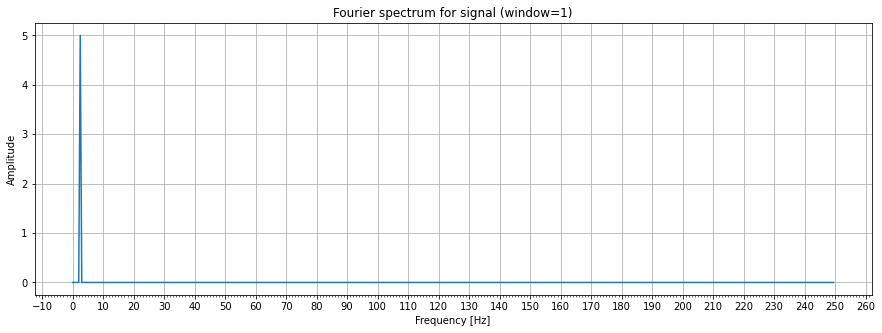

In [29]:
start = 0
N = 1000
step = 1
m = 128
dt = 0.002

lpw = Function(start, 2 * m + 1, step)
lpw.lpf(10 * dt, dt, m)
plt.figure(figsize=(15, 5))
lpw.display('Potter LPF weights', 'index', '')

funcFourier = Function(start, 2 * m + 1, step)
funcFourier.fourier_spectrum(lpw, 1, True, True, dt)
funcFourier.normalize()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Potter LP filter TF', 'Frequency [Hz]', '')

# LPF фильтр
funcConv = Function(start, N * dt, dt)
funcConv.convolution_func(funcFile, lpw)
plt.figure(figsize=(15, 5))
funcConv.display('Filtered signal', 'Time [sec]', 'Amplitude')

funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Fourier spectrum for signal (window=1)', 'Frequency [Hz]', 'Amplitude')

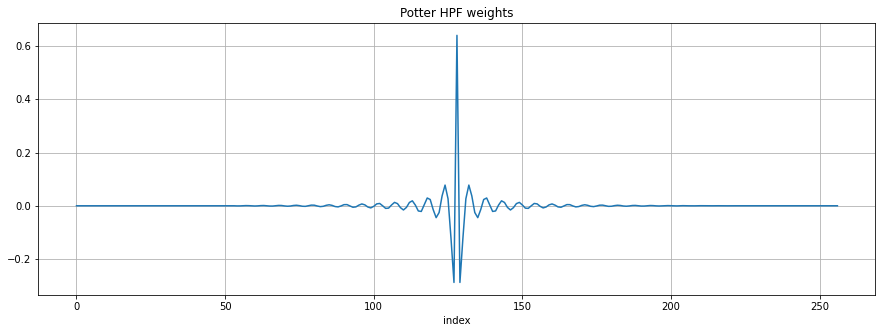

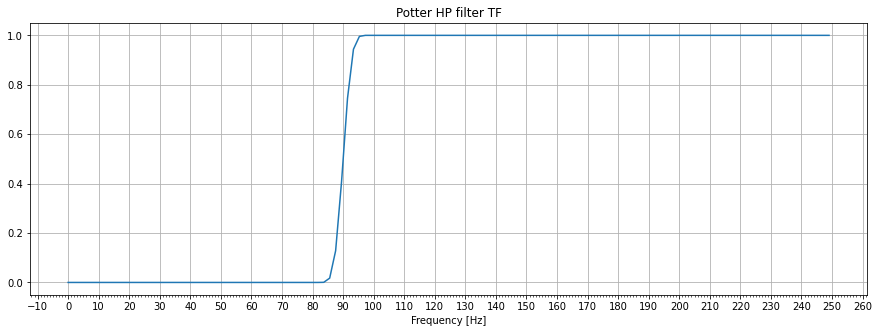

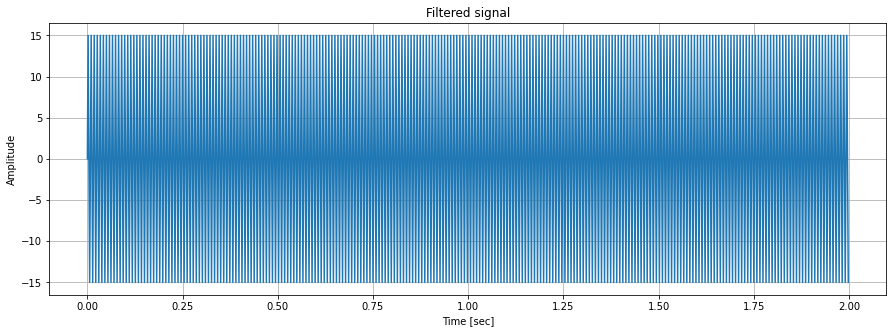

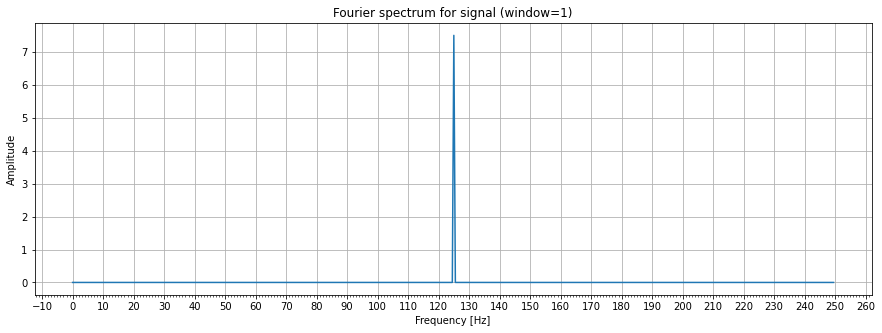

In [30]:
hpw = Function(start, 2 * m + 1, step)
hpw.hpf(90 * dt, dt, m)
plt.figure(figsize=(15, 5))
hpw.display('Potter HPF weights', 'index', '')

funcFourier = Function(start, 2 * m + 1, step)
funcFourier.fourier_spectrum(hpw, 1, True, True, dt)
funcFourier.normalize()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Potter HP filter TF', 'Frequency [Hz]', '')

# HPF фильтр
funcConv = Function(start, N * dt, dt)
funcConv.convolution_func(funcFile, hpw)
plt.figure(figsize=(15, 5))
funcConv.display('Filtered signal', 'Time [sec]', 'Amplitude')

funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Fourier spectrum for signal (window=1)', 'Frequency [Hz]', 'Amplitude')

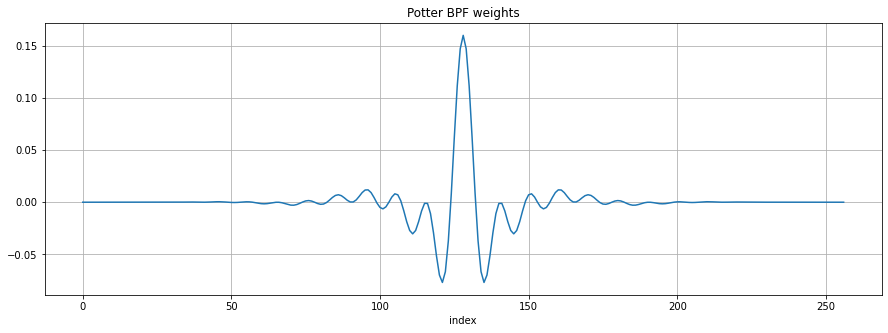

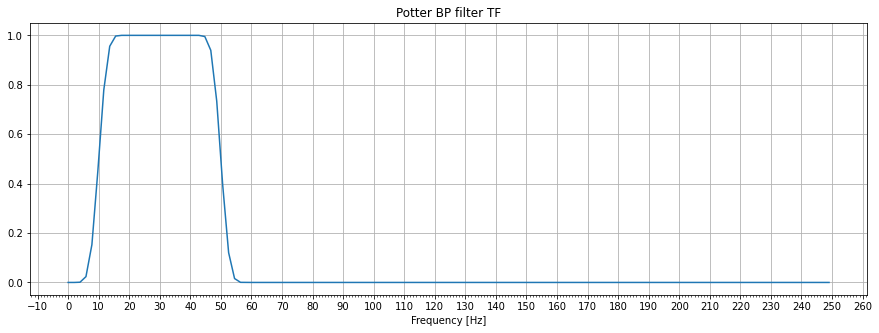

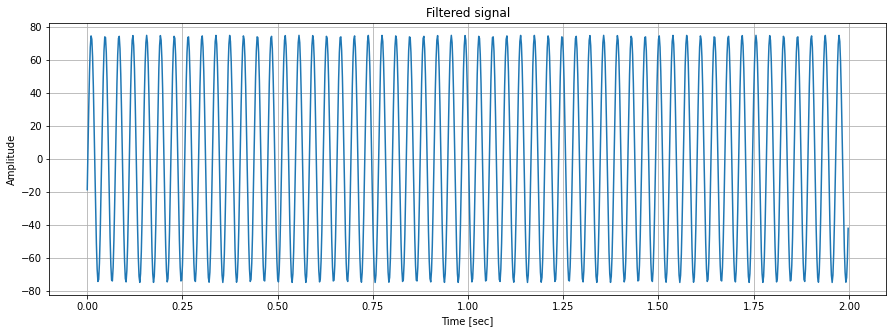

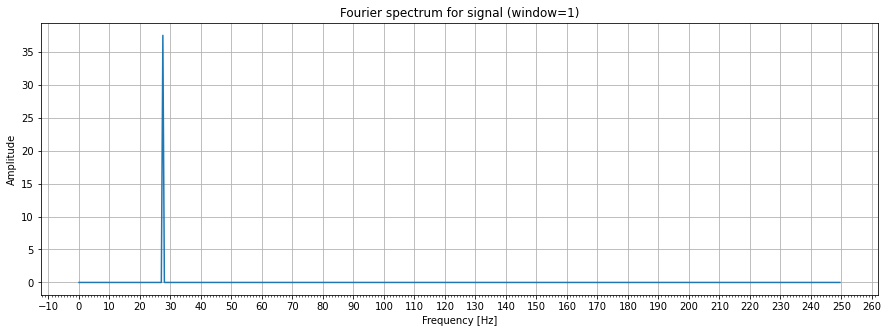

In [31]:
bpw = Function(start, 2 * m + 1, step)
bpw.bpf(10 * dt, 50 * dt, dt, m)
plt.figure(figsize=(15, 5))
bpw.display('Potter BPF weights', 'index', '')

funcFourier = Function(start, 2 * m + 1, step)
funcFourier.fourier_spectrum(bpw, 1, True, True, dt)
funcFourier.normalize()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Potter BP filter TF', 'Frequency [Hz]', '')

# BPF фильтр
funcConv = Function(start, N * dt, dt)
funcConv.convolution_func(funcFile, bpw)
plt.figure(figsize=(15, 5))
funcConv.display('Filtered signal', 'Time [sec]', 'Amplitude')

funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Fourier spectrum for signal (window=1)', 'Frequency [Hz]', 'Amplitude')

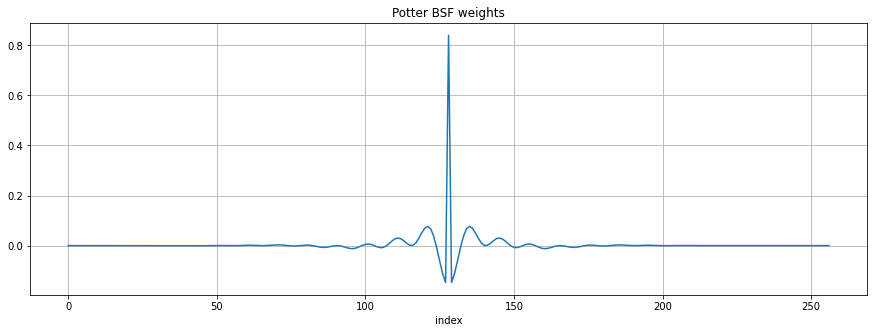

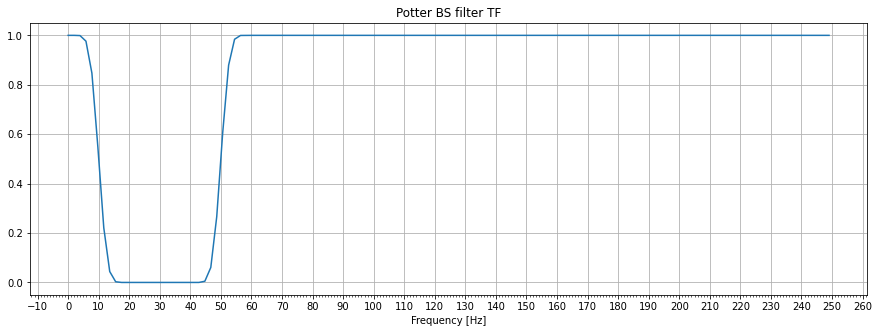

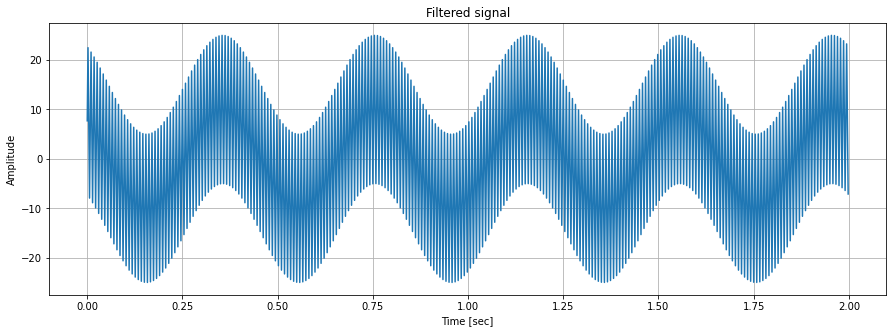

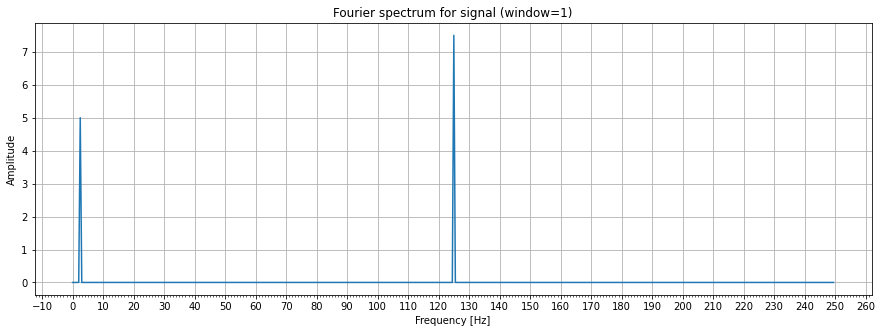

In [32]:
bsw = Function(start, 2 * m + 1, step)
bsw.bsf(10 * dt, 50 * dt, dt, m)
plt.figure(figsize=(15, 5))
bsw.display('Potter BSF weights', 'index', '')

funcFourier = Function(start, 2 * m + 1, step)
funcFourier.fourier_spectrum(bsw, 1, True, True, dt)
funcFourier.normalize()
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Potter BS filter TF', 'Frequency [Hz]', '')

# BSF фильтр
funcConv = Function(start, N * dt, dt)
funcConv.convolution_func(funcFile, bsw)
plt.figure(figsize=(15, 5))
funcConv.display('Filtered signal', 'Time [sec]', 'Amplitude')

funcFourier = Function(start, N, step)
funcFourier.fourier_spectrum(funcConv, 1, True, True, dt)
fig, ax = plt.subplots()
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))
fig.set_figwidth(15)
fig.set_figheight(5)
funcFourier.display('Fourier spectrum for signal (window=1)', 'Frequency [Hz]', 'Amplitude')

<h4><b>Задание 13:</b></h4>

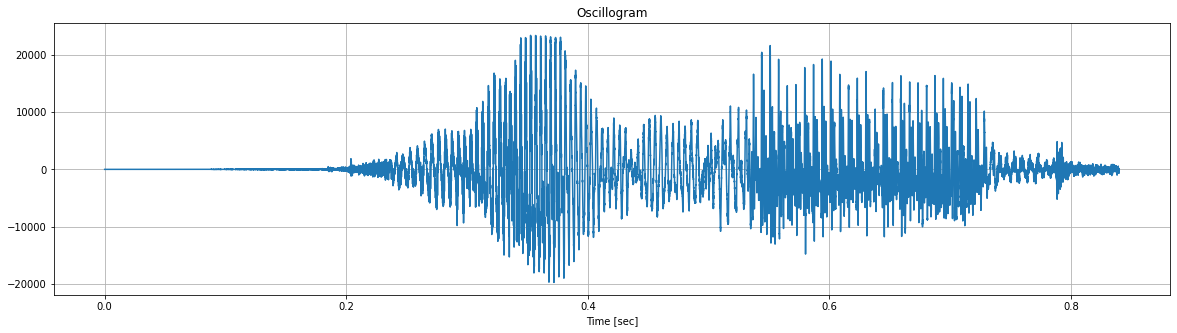

In [33]:
waveFunc = Function()
waveFunc.wave_func('tima.wav', 'rb')
plt.figure(figsize=(20, 5))
waveFunc.display('Oscillogram', 'Time [sec]', '')

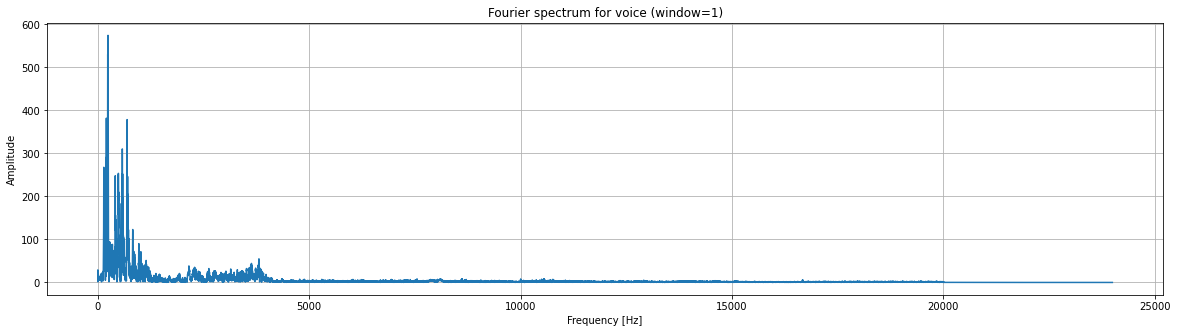

In [34]:
dt = 1 / 48000
funcFourier = Function(0, 40320, 1)
funcFourier.fourier_spectrum(waveFunc, 1, True, True, dt)
plt.figure(figsize=(20, 5))
funcFourier.display('Fourier spectrum for voice (window=1)', 'Frequency [Hz]', 'Amplitude')

(0.0, 5000.0)

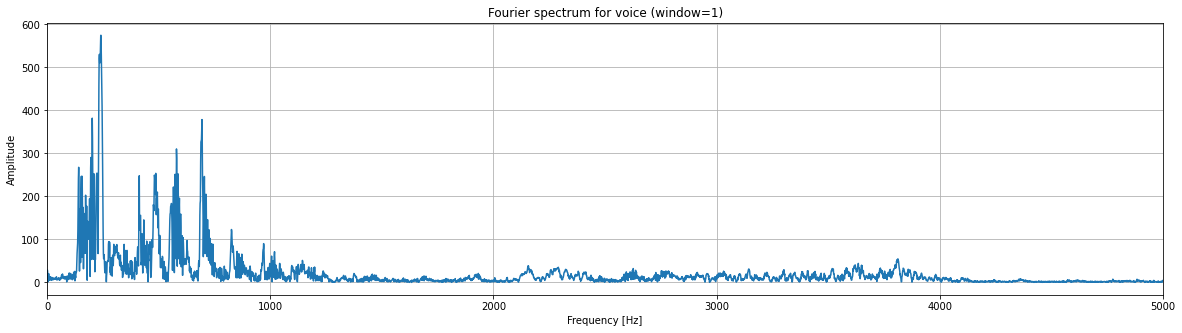

In [35]:
plt.figure(figsize=(20, 5))
funcFourier.display('Fourier spectrum for voice (window=1)', 'Frequency [Hz]', 'Amplitude')
plt.xlim(0, 5000)